## Persiapan Data

Kemiskinan merupakan masalah yang masih menjadi trending topic di seluruh negara, terutama di negara berkembang seperti Indonesia. Pengentasan kemiskinan merupakan tujuan pertama dari Sustainable Development Goals (SDGs) yang digagas oleh United Nations Development Programme (UNDP). Masalah kemiskinan juga seringkali dijadikan indikator untuk mengevaluasi kinerja pemerintah dalam meningkatkan taraf hidup rakyat.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid')
import matplotlib.pyplot as plt

import os
import sys
import json

from pandas.io.stata import StataReader

from matplotlib import pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))

## Load data
Load data .sav menggunakan paket pyreadstat
sedangkan load .csv cukup dengan menggunakan fungsi bawaan pandas.read_csv 

In [2]:
import pyreadstat
df_kor_rt, meta_kor_rt = pyreadstat.read_sav("C:\\Users\\Asus\\Documents\\TUTORIAL\\DUPAK\\Maret 2020\\14 SSN 202003\\14_ssn_202003_kor_rt.sav")
df_kor_ind1, meta_kor_ind1 = pyreadstat.read_sav("C:\\Users\\Asus\\Documents\\TUTORIAL\\DUPAK\\Maret 2020\\14 SSN 202003\\14_ssn_202003_kor_ind1.sav")
df_kor_ind2, meta_kor_ind2 = pyreadstat.read_sav("C:\\Users\\Asus\\Documents\\TUTORIAL\\DUPAK\\Maret 2020\\14 SSN 202003\\14_ssn_202003_kor_ind2.sav")
df_kp41, meta_kp41 = pyreadstat.read_sav("C:\\Users\\Asus\\Documents\\TUTORIAL\\DUPAK\\Maret 2020\\14 SSN 202003\\14_ssn_202003_kp41.sav")
df_kp42, meta_kp42 = pyreadstat.read_sav("C:\\Users\\Asus\\Documents\\TUTORIAL\\DUPAK\\Maret 2020\\14 SSN 202003\\14_ssn_202003_kp42.sav")
df_kp43, meta_kp43 = pyreadstat.read_sav("C:\\Users\\Asus\\Documents\\TUTORIAL\\DUPAK\\Maret 2020\\14 SSN 202003\\14_ssn_202003_kp43.sav")
riau_kons_41 = pd.read_csv("riau_kons.csv")
riau_kons_42 = pd.read_csv("riau_kons_42.csv")

In [3]:
print (df_kor_rt.shape, df_kor_ind1.shape, df_kor_ind2.shape)
print (df_kp41.shape, df_kp42.shape, df_kp43.shape)
print (riau_kons_41.shape, riau_kons_42.shape)

(8182, 240) (31721, 156) (31721, 157)
(417696, 27) (340036, 26) (8182, 22)
(8182, 175) (8182, 103)


## Menggabungkan/merge data
Menggabungkan data kor rumah tangga dengan data pengeluaran per kapita rumah tangga
Menggabungkan data dengan fungsi merge dari pandas

In [4]:
# Menggabungkan data kor dengan data pengeluaran per kapita
riau_rt = df_kor_rt.merge(df_kp43[["renum", "kapita", "weind"]], on='renum', how='left')
riau_rt.shape

(8182, 242)

In [5]:
# Memberikan label miskin berdasarkan garis kemiskinan maret 2020
# perkotaan 570462, perdesaan 526431
# perkotaan r105 =1, perdesaan r105=2
riau_rt['miskin'] = np.where((((riau_rt['r105'] == 1) & (riau_rt['kapita'] < 570462)) | 
                              ((riau_rt['r105'] == 2) & (riau_rt['kapita'] < 526431))), True, False)
riau_rt.shape

(8182, 243)

In [6]:
# Menggabungkan data kor riau dengan data variabel konsumsi komoditas
riau_rt = riau_rt.merge(riau_kons_41, on='renum', how='left')
riau_rt = riau_rt.merge(riau_kons_42, on='renum', how='left')
riau_rt.shape

(8182, 519)

In [7]:
# memecah menjadi sampel kota dan desa
# untuk mengecek apakah sesuai dengan p0 perkotaan dan perdesaan
riau_rt_kota = riau_rt[riau_rt['r105'] == 1]
riau_rt_desa = riau_rt[riau_rt['r105'] == 2]

print(riau_rt_kota.shape, riau_rt_desa.shape)

(3030, 519) (5152, 519)


## Mengecek apakah angka kemiskinan sudah sesuai

In [8]:
# persentase penduduk miskin riau (perkotaan+perdesaan) adalah 6,82
p0 = riau_rt.groupby('miskin').agg({'weind': 'sum'}).sort_values('weind', ascending=False)
p0['weind']=(p0['weind']*100)/p0['weind'].sum()
print(p0)

            weind
miskin           
False   93.180994
True     6.819006


In [9]:
# persentase penduduk miskin riau (perkotaan) adalah 6,12
p0_kota = riau_rt_kota.groupby('miskin').agg({'weind': 'sum'}).sort_values('weind', ascending=False)
p0_kota['weind']=(p0_kota['weind']*100)/p0_kota['weind'].sum()
print(p0_kota)

            weind
miskin           
False   93.875877
True     6.124123


In [10]:
# persentase penduduk miskin riau (perdesaan) adalah 7,29
p0_desa = riau_rt_desa.groupby('miskin').agg({'weind': 'sum'}).sort_values('weind', ascending=False)
p0_desa['weind']=(p0_desa['weind']*100)/p0_desa['weind'].sum()
print(p0_desa)

            weind
miskin           
False   92.711005
True     7.288995


In [ ]:
riau_rt.head()

## Build derived features from individual data 
##### Derived features:
* Number of children (age 10 and under) in household 
* Number of males in household (over 10 years old)
* Number of females in household (over 10 years old)
* Jumlah anggota keluarga yang dapat membaca dan menulis huruf latin/alfabe
* Jumlah anggota keluarga yang bekerja selama seminggu terakhir
* Jumlah anggota keluarga yang pernah menggunakan internet dalam tiga bulan terakhir

In [11]:
# Menggabungkan data individu
riau_ind = pd.concat([df_kor_ind1, df_kor_ind2], axis=1)
riau_ind.shape

(31721, 313)

In [12]:
# Membuang kolom yang duplikat
riau_ind = riau_ind.loc[:,~riau_ind.columns.duplicated()]
riau_ind.shape

(31721, 300)

In [ ]:
# riau_ind.to_csv('riau_ind.csv', index = False, header=True)

In [ ]:
# riau_rt.r304.sum().astype(int)

In [ ]:
# (riau_ind.r407 >= 10).sum().astype(int)

In [ ]:
# Number of children (age 10 and under) in household
# riau_ind.groupby(['renum'])[['der_nchild10under']].agg('sum')

In [13]:
def add_derived_feature(df_rt, 
                        df_ind, 
                        feature_name, 
                        value, 
                        ):
    '''Menambahkan variabel baru ke data rumah tangga'''
    df_ind['der_' + feature_name] = value
    value2 = df_ind.groupby(['renum'])[['der_' + feature_name]].agg('sum')
    value2['renum'] = value2.index
    value2.reset_index(drop=True,level=0, inplace=True)
    df_rt = df_rt.merge(value2, on='renum', how='left')
    return df_rt

In [14]:
# IDN - Number of children (Under 10) in household
value = pd.DataFrame(riau_ind.r407 < 10).sum(level=0).astype(int)
riau_rt = add_derived_feature(riau_rt, riau_ind, 'nchild10under', value)
riau_rt.head()

,D_R,r101,r102,r105,nuinfort,r1701,r1702,r1703,r1704,r1705,...,kons_301,kons_302,kons_303,kons_305,kons_306,kons_307,kons_308,kons_309,kons_310,der_nchild10under
0,,14.0,1.0,2.0,2.0,5.0,5.0,5.0,5.0,5.0,...,0,0,0,0,0,0,0,0,0,0
1,,14.0,1.0,2.0,1.0,5.0,5.0,5.0,5.0,1.0,...,1,0,0,0,0,0,0,0,0,3
2,,14.0,1.0,2.0,2.0,5.0,5.0,5.0,5.0,5.0,...,1,0,0,0,0,0,0,0,0,0
3,,14.0,1.0,2.0,2.0,5.0,5.0,5.0,5.0,5.0,...,0,0,0,0,0,0,0,0,0,0
4,,14.0,1.0,2.0,1.0,1.0,1.0,1.0,5.0,5.0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
# IDN - Number of males and females in household >= 10
value = pd.DataFrame((riau_ind.r407 >= 10) & (riau_ind.r405 == 1)).sum(level=0).astype(int)
riau_rt = add_derived_feature(riau_rt, riau_ind, 'nmalesover10', value)
riau_rt.shape

(8182, 521)

In [16]:
# IDN - Number of males and females in household >= 10
value = pd.DataFrame((riau_ind.r407 >= 10) & (riau_ind.r405 == 2)).sum(level=0).astype(int)
riau_rt = add_derived_feature(riau_rt, riau_ind, 'nfemalesover10', value)
riau_rt.shape

(8182, 522)

In [17]:
# IDN - Jumlah anggota rumah tangga yang dapat membaca dan menulis huruf latin/alfabet
value = pd.DataFrame(riau_ind.r609 == 1).sum(level=0).astype(int)
riau_rt = add_derived_feature(riau_rt, riau_ind, 'nliterate', value)
riau_rt.shape

(8182, 523)

In [18]:
# IDN - Jumlah anggota rumah tangga yang bekerja selama seminggu terakhir
value = pd.DataFrame(riau_ind.r702_a == 'A').sum(level=0).astype(int)
riau_rt = add_derived_feature(riau_rt, riau_ind, 'nbekerja', value)
riau_rt.shape

(8182, 524)

In [19]:
# IDN - Jumlah anggota rumah tangga yang pernah menggunakan internet dalam tiga bulan terakhir
value = pd.DataFrame(riau_ind.r808 == 1).sum(level=0).astype(int)
riau_rt = add_derived_feature(riau_rt, riau_ind, 'ninternetpast3mo', value)
riau_rt.shape

(8182, 525)

### Mengecek variabel konsumi mana yang paling banyak di konsumsi
Keterangan : variabel dengan awalan kons

In [20]:
# Filter consumables and group by poor/non-poor
consumable_columns = [x for x in riau_rt.columns if x.startswith('kons_')]
consumables = (riau_rt.groupby('miskin')[consumable_columns].sum().T)

consumables.columns = ['tidak_miskin', 'miskin']
consumables['total'] = consumables.sum(axis=1)
consumables['percent'] = consumables.total / riau_rt.shape[0]

# Display the top 10 most common consumables
consumables.sort_values('percent', ascending=False).head(20)

,tidak_miskin,miskin,total,percent
kons_232,7772,398,8170,0.998533
kons_235,7719,397,8116,0.991934
kons_2,7632,402,8034,0.981912
kons_197,7589,381,7970,0.974089
kons_134,7519,396,7915,0.967367
kons_233,7456,372,7828,0.956734
kons_92,7428,389,7817,0.955390
kons_122,7367,387,7754,0.947690
kons_126,7366,366,7732,0.945001
kons_227,7360,350,7710,0.942312


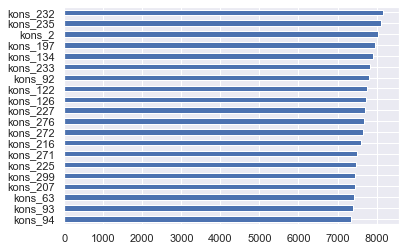

In [21]:
# Plot the top 10 most common consumables
(consumables.total
            .sort_values(ascending=False)
            .head(20)
            .sort_values(ascending=True).plot.barh());

In [22]:
consumables['difference'] = (consumables.tidak_miskin - consumables.miskin) / consumables.total

# Display the top 20 most common consumables
display(consumables.sort_values('difference', ascending=False).head(20))

,tidak_miskin,miskin,total,percent,difference
kons_310,75,0,75,0.009166,1.000000
kons_285,156,0,156,0.019066,1.000000
kons_88,184,0,184,0.022488,1.000000
kons_308,69,0,69,0.008433,1.000000
kons_100,18,0,18,0.002200,1.000000
kons_50,74,0,74,0.009044,1.000000
kons_104,36,0,36,0.004400,1.000000
kons_105,11,0,11,0.001344,1.000000
kons_15,14,0,14,0.001711,1.000000
kons_59,29,0,29,0.003544,1.000000


## Create Train/Test Split and Save Data

As a final step, we want to split the data into training and test sets which will be used by all of the algorithms. We'll reserve 25% of the data as a test set.

In [23]:
# Split data menjadi training set dan tes set

riau_train, riau_test = train_test_split(riau_rt,
                                        test_size=0.25,
                                        random_state=1443,
                                        stratify=riau_rt.miskin)

In [24]:
# Simpan data ke file
riau_train.to_csv("Susenas_Maret_2020\\riau_train.csv", index = False, header=True)
riau_test.to_csv("Susenas_Maret_2020\\riau_test.csv", index = False, header=True)

## Tambahan
### Membuat data khusus dummy variabel data konsumsi
* riau_kons dari kp41
* riau_kons_42 dari kp42
* Keterangan : uncomment untuk menjalankan (ctrl+/)

### riau_kons dari kp41

In [ ]:
# riau_kons = pd.DataFrame(riau_rt["renum"], columns=['renum'])
# riau_kons.head()

In [ ]:
# for x in range(1,189):
#     riau_kons['kons_'+ str(x)] = 0
# riau_kons.shape

In [ ]:
# riau_kons.head()

In [ ]:
# riau_kons.loc[riau_kons['renum'] == 46056]

In [ ]:
# riau_kons.loc[riau_kons['renum'] == 46056, 'kons_'+ str(1)] = 0

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
# for i in range(1): 
#     riau_kons.loc[riau_kons['renum'] == df_kp41.loc[i, "renum"], 'kons_' + str(df_kp41.loc[i, "kode"].astype(int))] = 0
#     print(df_kp41.loc[i, "renum"], 'kons_' + str(df_kp41.loc[i, "kode"].astype(int)))

In [ ]:
# for i in range(len(df_kp41)): 
#     riau_kons.loc[riau_kons['renum'] == df_kp41.loc[i, "renum"], 'kons_' + str(df_kp41.loc[i, "kode"].astype(int))] = 1 

In [ ]:
# riau_kons.head()

In [ ]:
# riau_kons.to_csv('riau_kons.csv', index = False, header=True)

### riau_kons_42 dari kp42

In [ ]:
# riau_kons_42 = pd.DataFrame(riau_rt["renum"], columns=['renum'])
# riau_kons_42.head()

In [ ]:
# for x in range(189,311):
#     riau_kons_42['kons_'+ str(x)] = 0
# riau_kons_42.shape

In [ ]:
# riau_kons_42.head()

In [ ]:
# for i in range(len(df_kp42)): 
#     riau_kons_42.loc[riau_kons_42['renum'] == df_kp42.loc[i, "renum"], 'kons_' + str(df_kp42.loc[i, "kode"].astype(int))] = 1 

In [ ]:
# riau_kons_42.head()

In [ ]:
# riau_kons_42.to_csv('riau_kons_42.csv', index = False, header=True)